## Problem Statement

The Ames Housing board is looking to see how we can predict the prices of future houses, based on a list of features. These features are a combination of nominal, ordinal, continuous and discrete values.

To do that, the board has tasked you and the team to create a prediction model that can predict the prices of houses within Ames, given a list of features that may or may not contribute to the sale price of a house.

### Contents:

* Data import, helper functions, cleaning and mapping of ordinal values
* EDA: Previewing Data and Highlighting Outliers
* Testing on Various Regression Models
* Applying our selected model on the Kaggle test set
* Conclusion

### Datasets:

2 datasets have been used for this project as shown below:

* [`test.csv`](./datasets/train.csv): 2006 to 2010 housing information of Ames, Iowa. Inclusive of SalePrice
* [`new_test.csv`](./datasets/new_test.csv): Kaggle test set to use to predict house prices.

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

#### Read data and segregate ordinal, nominal, continuous and discrete features

In [2]:
train = pd.read_csv('./datasets/train.csv')

Here, we list and segregate the various features according to the data dictionary for convenience if we need to do any specific mapping or accessing of a group of data.

In [3]:
# 23 Nominal, 23 Ordinal, 14 Discrete, 20 Continuous

ord_features = [
    'Lot Shape',
    'Utilities',
    'Land Slope',
    'Overall Qual',
    'Overall Cond',
    'Exter Qual',
    'Exter Cond',
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
    'Heating QC',
    'Electrical',
    'Kitchen Qual',
    'Functional',
    'Fireplace Qu',
    'Garage Finish',
    'Garage Qual',
    'Garage Cond',
    'Paved Drive',
    'Pool QC',
    'Fence'    
]

nom_features = [
    'PID', #** Exclude PID as nom observation ids
    'MS SubClass',
    'MS Zoning',
    'Street',
    'Alley',
    'Land Contour',
    'Lot Config',
    'Neighborhood',
    'Condition 1',
    'Condition 2',
    'Bldg Type',
    'House Style',
    'Roof Style',
    'Roof Matl',
    'Exterior 1st',
    'Exterior 2nd',
    'Mas Vnr Type',
    'Foundation',
    'Heating',
    'Central Air',
    'Garage Type',
    'Misc Feature',
    'Sale Type',
#     'Sale Condition'
]

cont_features = [
    'Lot Frontage',
    'Lot Area',
    'Mas Vnr Area',
    'BsmtFin SF 1',
    'BsmtFin SF 2',
    'Bsmt Unf SF',
    'Total Bsmt SF',
    '1st Flr SF',
    '2nd Flr SF',
    'Low Qual Fin SF',
    'Gr Liv Area',
    'Garage Area',
    'Wood Deck SF',
    'Open Porch SF',
    'Enclosed Porch',
    '3Ssn Porch',
    'Screen Porch',
    'Pool Area',
    'Misc Val',
    #'SalePrice'
]


disc_features = [
    'Id',
    'Year Built',
    'Year Remod/Add',
    'Bsmt Full Bath',
    'Bsmt Half Bath',
    'Full Bath',
    'Half Bath',
    'Bedroom AbvGr',
    'Kitchen AbvGr',
    'TotRms AbvGrd',
    'Fireplaces',
    'Garage Yr Blt',
    'Garage Cars',
    'Mo Sold',
    'Yr Sold'
]


### Define helper functions

Helper functions are instantiated here to preload them, as they will be used for data cleaning and filtering later on.

#### Check NaN Values

In [4]:
def check_nan_values(df, col_lst):
    """
    Function checks for any NaN values in the provided list of features and returns list of features found to have
    NaN values
    
    Input -> Dataframe df, List col_lst
    Returns -> List ft_lst
    """
    ft_lst = []
    for feature in df.loc[:,(df[col_lst].isnull().sum() > 0).index].columns:
        if df[feature].isnull().values.any():
            ft_lst.append(feature)
    return ft_lst


In [5]:
def clean_data(df):
    """
    Function does data cleaning on dataset by filling NaN values with NA or 0, based on the type of feature in accordance
    to data dictionary
    
    Input -> Dataframe df
    Returns -> Dataframe df
    """
    
    # Clean nominal features
    df['Alley'] = df['Alley'].fillna('NA')
    df['Garage Type'] = df['Garage Type'].fillna('NA')
    df['Misc Feature'] = df['Misc Feature'].fillna('None')
    df['Mas Vnr Type'] = df['Mas Vnr Type'].map(lambda x: 'CBlock' if pd.isnull(x) else x)
    df['Central Air'] = df['Central Air'].map(lambda x: 1 if x == 'Y' else 0)
    
    # Clean Ordinal features
    for ft in check_nan_values(df,ord_features):
        df[ft] = df[ft].fillna('NA')
        
    # Clean continuous features
    for ft in check_nan_values(df,cont_features):
        df[ft] = df[ft].fillna(0)
        
    # Clean discrete features
    for ft in check_nan_values(df,disc_features):
        df[ft] = df[ft].fillna(0)
        
    return df

In [6]:
def ord_mapping(df):
    """
    Function specifically maps ordinal features to ranked integers. As the ordinal values are not sorted, and some 
    features have different ordinal values, they are individually mapped and ranked.
    
    Input -> Dataframe df
    Returns -> Dataframe df
    """
    
    
    df['Lot Shape'] = df['Lot Shape'].map({'IR1':0,'IR2':1, 'IR3':2,'Reg':3,})
    df['Utilities'] = df['Utilities'].map({'ELO':0,'NoSeWa':1, 'NoSewr':2,'AllPub':3})
    df['Land Slope'] = df['Land Slope'].map({'Sev':0, 'Mod':1,'Gtl':2})
    df['Exter Qual'] = df['Exter Qual'].map({'Po':0,'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    df['Exter Cond'] = df['Exter Cond'].map({'Po':0,'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    df['Bsmt Qual'] = df['Bsmt Qual'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['Bsmt Cond'] = df['Bsmt Cond'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['Bsmt Exposure'] = df['Bsmt Exposure'].map({'NA':0, 'No':1, 'Mn':2,'Av':3, 'Gd':4})
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
    df['Heating QC'] = df['Heating QC'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
    df['Electrical'] = df['Electrical'].map({'Mix':0,'FuseP':1,'FuseF':2,'FuseA':3,'SBrkr':4})
    df['Kitchen Qual'] = df['Kitchen Qual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
    df['Functional'] = df['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
    df['Fireplace Qu'] = df['Fireplace Qu'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    df['Garage Finish'] = df['Garage Finish'].map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
    df['Garage Qual'] = df['Garage Qual'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    df['Garage Cond'] = df['Garage Cond'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    df['Paved Drive'] = df['Paved Drive'].map({'N':0,'P':1,'Y':2})
    df['Pool QC'] = df['Pool QC'].map({'NA':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
    df['Fence'] = df['Fence'].map({'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
    return df

In [7]:
def check_frequency(df):
    
    """
    Function checks for frequency of values to measure first value of each feature, and see if it's skewed towards
    one value for every row, or if it's evenly spread, based on threshold of 70%
    
    Input -> Dataframe df
    Returns -> List[List,List] [keep_lst,remove_lst]
    """
    
    keep_lst = []
    remove_lst = []
    for feature in df.columns:
        if round((df[feature].value_counts().to_list()[0]/sum(df[feature].value_counts().to_list())) * 100,2) < 70:
            keep_lst.append(feature)
        else:
            remove_lst.append(feature)
        
    return [keep_lst, remove_lst]

In [8]:
def plot_3_scatter(df, columns, x):
    
    """
    Function takes in dataframe to show each feature and it's spread vs another feature (x)
    
    Input -> Dataframe df, List columns, String x
    
    """
    
    rows = round(len(columns)/3) if len(columns)%3 ==0 else round(len(columns)/3)+1
    
    fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15,15*3))
    axr = axes.ravel()
    for idx, feature in enumerate(columns):
        scatter = sns.scatterplot(
            data=df,
            x=df[feature],
            y=df[x],
            ax=axr[idx]
        )

        scatter.set_xlabel(feature)
        scatter.set_ylabel(x)
    plt.tight_layout()
    if len(columns) % 3 != 0:
        axr.flat[-(len(columns)%3)].set_visible(False)
    plt.show()

In [9]:
def interaction_terms(df):
    df['Age'] = abs(df['Year Built'] - df['Yr Sold'])
    df['Overall Qual Liv Area'] = df['Overall Qual'] * df['Gr Liv Area']
    df['Overall Qual Ext Qual'] = df['Overall Qual'] * df['Exter Qual']
    return df

In [10]:
def drop_collinear(df):
    # Drop columns as they are represented by Total Bsmt Area, and Lot area, and are most likely collinear in nature
    df = df.drop(columns=['Id','PID','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','1st Flr SF','2nd Flr SF','Mo Sold','Yr Sold'])
    return df

In [11]:
def adjust_col_names(df):
    """
    Function takes in dataframe and lowercases feature names, and replaces spaces with underscore
    
    Input -> Dataframe df
    Returns -> Dataframe df
    
    """
    for col_name in df.columns:
        df.rename(columns={col_name: col_name.lower().replace(' ','_')}, inplace=True)
    return df

#### Clean and fix data with NaN

Clean dataset and map ordinal data

In [12]:
data = clean_data(train)
# train.info()

#### Ordinal column mapping

Here, we map and rank the ordinal features into a numeric rank, which will be used later when we run our regression models

In [13]:
data = ord_mapping(data)

We observe 1 record of Garage Yr Built at Year 2207. Deduced to be typo and imputed 2007 instead

In [14]:
data['Garage Yr Blt'].describe()   # Noted typo of 2207. Deduced to be 2007 instead

count    2051.000000
mean     1868.725987
std       454.133654
min         0.000000
25%      1957.000000
50%      1978.000000
75%      2001.000000
max      2207.000000
Name: Garage Yr Blt, dtype: float64

In [15]:
data.loc[data['Garage Yr Blt'] == 2207, 'Garage Yr Blt'] = 2007

We then introduce some additional features which are more useful, such as age of the house. This would be easier to deduce instead of looking at the year the house was built and the year it was sold.

Later on, we see that some features, such as the overall quality, the grade of the living area and the quality of the materials used in the exterior, show a strong correlation to the sale price of a house. We combine and add these features to form interaction terms, which will contribute to the predictive results.

In [16]:
data = interaction_terms(data)

We also see some collinear data which do not necessarily contribute much, as there are totals which would be the summation of these 2 or more features already. Additionally, some features such as Id and PID, do not provide much information or relation to the housing prices as they are more of indexes instead.

To prevent overfitting, we drop these columns

In [17]:
data = drop_collinear(data)

We then adjust the feature names for easier use and manipulation of the data.

In [18]:
data = adjust_col_names(data)

#### Check head and tail of fixed data

In [19]:
data.head(3)

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_area,pool_qc,fence,misc_feature,misc_val,sale_type,saleprice,age,overall_qual_liv_area,overall_qual_ext_qual
0,60,RL,0.0,13517,Pave,NA,0,Lvl,3,CulDSac,...,0,0,0,None,0,WD,130500,34,8874,18
1,60,RL,43.0,11492,Pave,NA,0,Lvl,3,CulDSac,...,0,0,0,None,0,WD,220000,13,14854,21
2,20,RL,68.0,7922,Pave,NA,3,Lvl,3,Inside,...,0,0,0,None,0,WD,109000,57,5285,10


In [20]:
data.tail(3)

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_area,pool_qc,fence,misc_feature,misc_val,sale_type,saleprice,age,overall_qual_liv_area,overall_qual_ext_qual
2048,50,RL,57.0,7558,Pave,NA,3,Bnk,3,Inside,...,0,0,0,None,0,WD,177000,81,11478,12
2049,20,RL,80.0,10400,Pave,NA,3,Lvl,3,Corner,...,0,0,0,None,0,WD,144000,53,4800,8
2050,60,RL,60.0,7500,Pave,NA,3,Lvl,3,Inside,...,0,0,0,None,0,WD,189000,11,12628,14


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ms_subclass            2051 non-null   int64  
 1   ms_zoning              2051 non-null   object 
 2   lot_frontage           2051 non-null   float64
 3   lot_area               2051 non-null   int64  
 4   street                 2051 non-null   object 
 5   alley                  2051 non-null   object 
 6   lot_shape              2051 non-null   int64  
 7   land_contour           2051 non-null   object 
 8   utilities              2051 non-null   int64  
 9   lot_config             2051 non-null   object 
 10  land_slope             2051 non-null   int64  
 11  neighborhood           2051 non-null   object 
 12  condition_1            2051 non-null   object 
 13  condition_2            2051 non-null   object 
 14  bldg_type              2051 non-null   object 
 15  hous

#### EDA: Previewing Data and Highlighting Outliers

We see that there are 2 outliers in the data set, shown as markers way beyond the 99% quartile. This is also specifically mentioned in the data dictionary for the training dataset.

<Figure size 1080x1080 with 0 Axes>

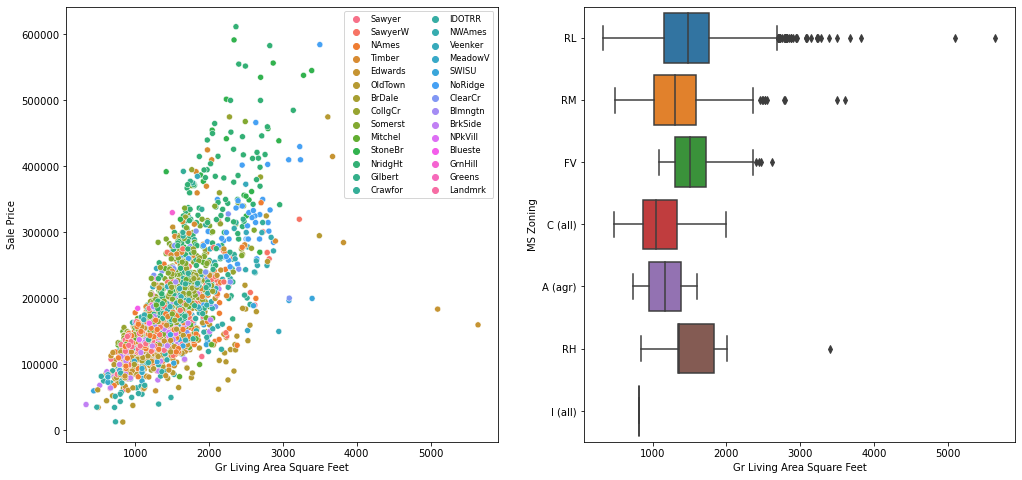

In [22]:
plt.figure(figsize=(15,15))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))
sns.scatterplot(data=data, y='saleprice',x='gr_liv_area', hue='neighborhood',ax=axes[0])
axes[0].legend(ncol=2, fontsize='small')
axes[0].set_xlabel('Gr Living Area Square Feet')
axes[0].set_ylabel('Sale Price')
sns.boxplot(data=data,y='ms_zoning', x='gr_liv_area',ax=axes[1])
axes[1].set_xlabel('Gr Living Area Square Feet')
axes[1].set_ylabel('MS Zoning')
plt.show();

We can see 2 records exceeding the 99th quantile of the whole dataset by 3 times of standard deviation. To prevent these 2 outliers from skewing our fitting later when we perform our models, we will exclude these 2 records from our dataset. We now see a better spread of the data.

In [23]:
data.drop(data[data['gr_liv_area'] > data['gr_liv_area'].quantile(.99) + (data['gr_liv_area'].std() * 3)].index, inplace=True)
data.reset_index(inplace=True)

<Figure size 1080x1080 with 0 Axes>

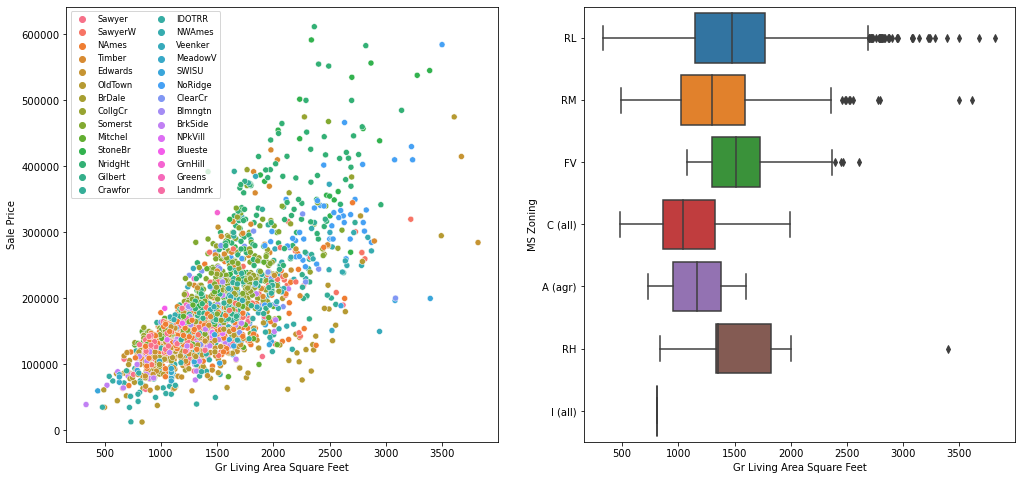

In [24]:
plt.figure(figsize=(15,15))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))
sns.scatterplot(data=data, y='saleprice',x='gr_liv_area', hue='neighborhood',ax=axes[0])
axes[0].legend(ncol=2, fontsize='small')
axes[0].set_xlabel('Gr Living Area Square Feet')
axes[0].set_ylabel('Sale Price')
sns.boxplot(data=data,y='ms_zoning', x='gr_liv_area',ax=axes[1])
axes[1].set_xlabel('Gr Living Area Square Feet')
axes[1].set_ylabel('MS Zoning')
plt.show();

When we see the data in the scatter diagram with the square feet of the ground living area versus the Sale Price, we can see that as the sale price and the square feet of the ground living area increases, the overall quality also increases. The pattern is noted in the chart on the right, with blue showing houses with lower quality, correlated to lower sale price and ground living area square feet, and gradually increasing as the square feet of the living area increases.

We also see that the better the quality of the materials used for the exterior, the higher the sale price. However, we do see some houses with large living areas showing lower quality of materials used for the exterior. This could possibly be a reason as to why their sale price are not valued higher despite the large living space.

The quality of the exterior shows a similar cluster to the overall quality, which could attribute that a better quality of the exterior is a factor in the overall quality of the house.

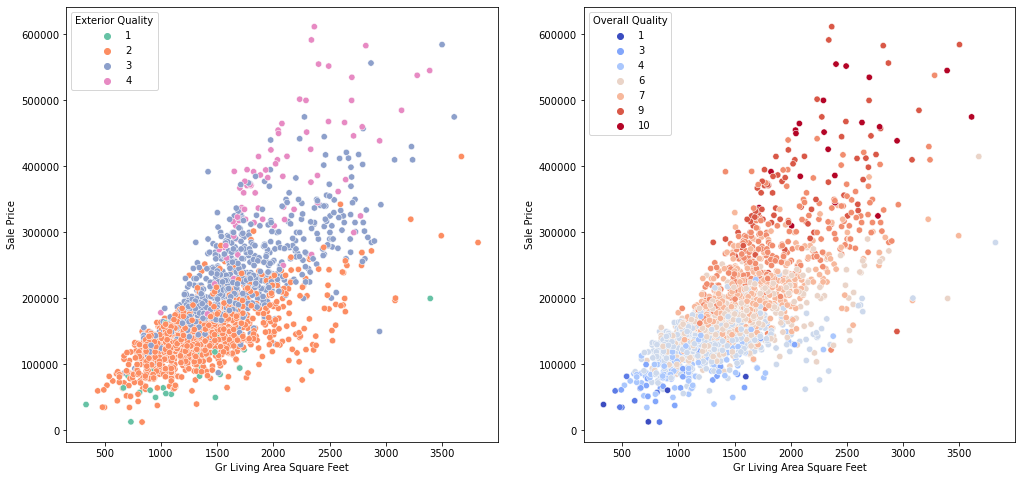

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,8))
sns.scatterplot(data=data,x='gr_liv_area',y='saleprice',hue='exter_qual',palette='Set2', s=40, ax=axes[0])
axes[0].legend(title='Exterior Quality')
axes[0].set_xlabel('Gr Living Area Square Feet')
axes[0].set_ylabel('Sale Price')
sns.scatterplot(data=data,x='gr_liv_area',y='saleprice',hue='overall_qual',palette='coolwarm', s=40, ax=axes[1])
axes[1].legend(title='Overall Quality')
axes[1].set_xlabel('Gr Living Area Square Feet')
axes[1].set_ylabel('Sale Price')
plt.show();

This would suggest that the creation of interaction terms between overall quality (overall_qual), square foot of living area (gr_liv_area) and quality of exterior materials (exter_qual) might be significantly correlated to the saleprice. We can see the coefficients based on the correlation heatmap below.

<AxesSubplot:>

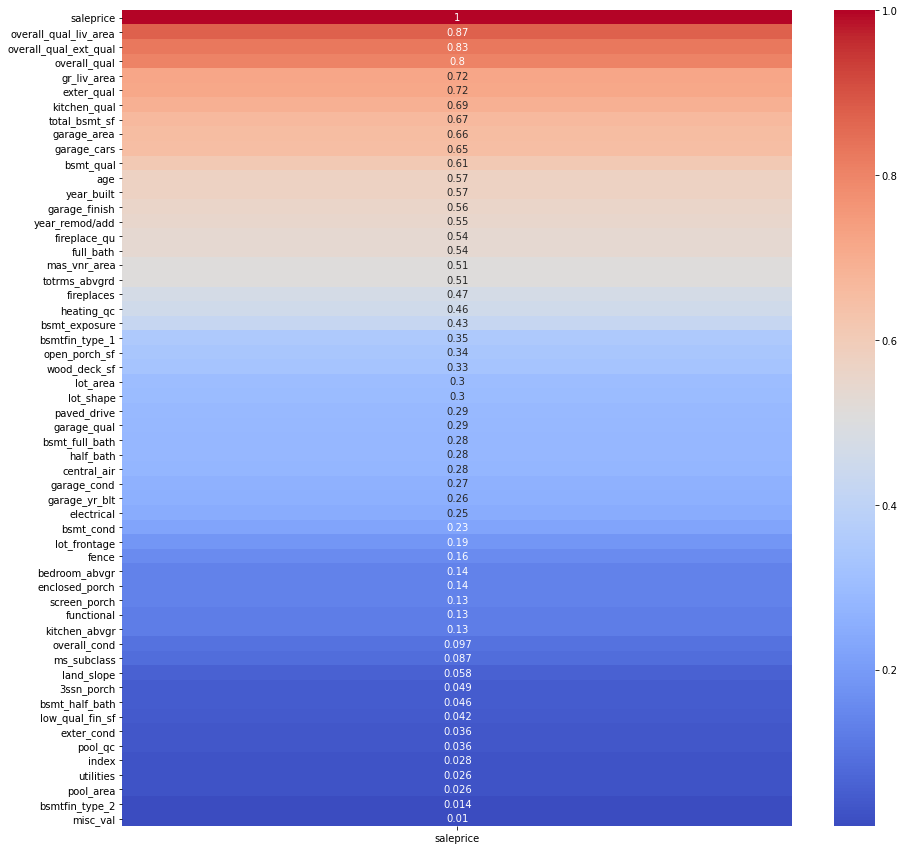

In [26]:
plt.figure(figsize=(15,15))
sns.heatmap(abs(data.corr()[['saleprice']]).sort_values(ascending=False, by='saleprice'), annot=True, cmap='coolwarm')

#### Extract main features to main dataframe

There are categorical, nominal and possibly discrete features that have majority of the values skewed to more than 70% of the 2049 records in the train set. The check_frequency function assesses all the features in the train dataset, uses 70% as a threshold and picks out features that doesn't have any values appearing more than 70% of the time. These features are then used as the main dataframe to train and fit our regression models for prediction.

As shown in the scatter plots below, we can see the various features showing more than 70% of records skewed to only one value, which doesn't show much variance in the feature

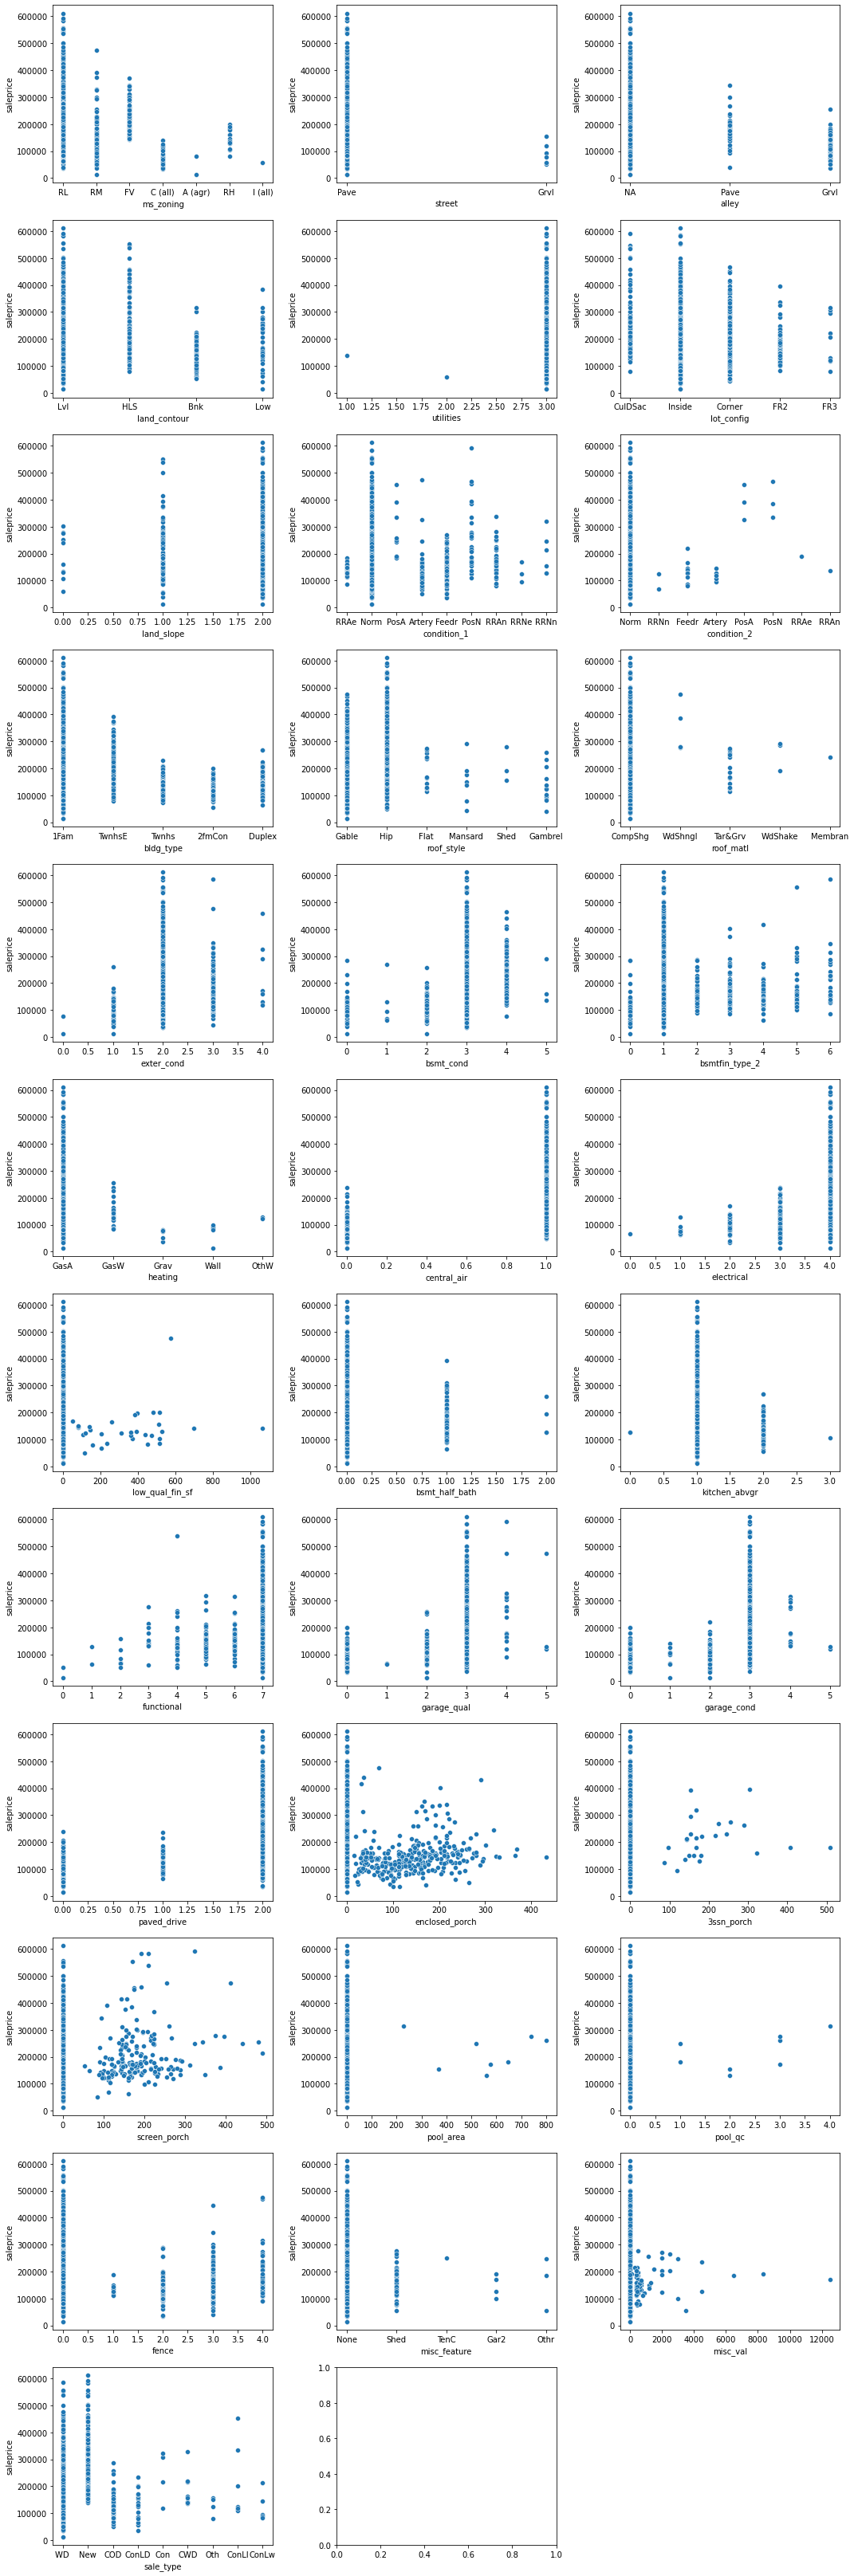

In [27]:
plot_3_scatter(data,check_frequency(data)[1],'saleprice')

Therefore, we take the features that are well spreaded across and use those features in our main dataset for our training models.

In [28]:
ft_to_keep = check_frequency(data)[0]
ft_to_keep.remove('index')
new_data = data[ft_to_keep]

After filtering out data that has a good spread without exceeding 70% of majority among it's values, we will use these features for our models, of which 34 are numeric which is a mix of ordinal, continuous and discrete features. The remaining 7 are nominal features which we will need to do one-hot encoding in order to fit it into our regression models.

In [29]:
new_data.select_dtypes(include='int64').head(3)

,ms_subclass,lot_area,lot_shape,overall_qual,overall_cond,year_built,year_remod/add,exter_qual,bsmt_qual,bsmt_exposure,...,totrms_abvgrd,fireplaces,fireplace_qu,garage_finish,wood_deck_sf,open_porch_sf,saleprice,age,overall_qual_liv_area,overall_qual_ext_qual
0,60,13517,0,6,8,1976,2005,3,3,1,...,6,0,0,2,0,44,130500,34,8874,18
1,60,11492,0,7,5,1996,1997,3,4,1,...,8,1,3,2,0,74,220000,13,14854,21
2,20,7922,3,5,7,1953,2007,2,3,1,...,5,0,0,1,0,52,109000,57,5285,10


In [30]:
new_data.select_dtypes(include='float64').head(3)

,lot_frontage,mas_vnr_area,total_bsmt_sf,bsmt_full_bath,garage_yr_blt,garage_cars,garage_area
0,0.0,289.0,725.0,0.0,1976.0,2.0,475.0
1,43.0,132.0,913.0,1.0,1997.0,2.0,559.0
2,68.0,0.0,1057.0,1.0,1953.0,1.0,246.0


In [31]:
new_data.select_dtypes(include='object').head(3)

,neighborhood,house_style,exterior_1st,exterior_2nd,mas_vnr_type,foundation,garage_type
0,Sawyer,2Story,HdBoard,Plywood,BrkFace,CBlock,Attchd
1,SawyerW,2Story,VinylSd,VinylSd,BrkFace,PConc,Attchd
2,NAmes,1Story,VinylSd,VinylSd,None,CBlock,Detchd


## Testing on Various Regression Models

### Model 1: Selection of small features assumed to be best suited

We do a small sample of some features which are highly correlated to Sale Price, as shown in our heatmap earlier. We will then split this sample model for training and validation over a 80%:20% ratio of the whole dataset. The random state will allow us to maintain the same results for reproducibility.

In [32]:
X = new_data[['overall_qual','gr_liv_area','exter_qual','age']]
y = new_data['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Based on the coefficients, we can see that the overall quality feature has a large and significant negative effect on the result.

In [33]:
coeff = pd.DataFrame({'Feature': X_train.columns.tolist(), 'Coefficients':lr.coef_})
coeff

,Feature,Coefficients
0,overall_qual,16907.046303
1,gr_liv_area,73.355940
2,exter_qual,27887.797276
3,age,-459.737201


We can see the performance of our model based on the RMSE, which shows the standard deviation of the residuals.

In [34]:
print(f'Train RMSE: {mean_squared_error(y_train,lr.predict(X_train))**0.5}')
print(f'Test RMSE: {mean_squared_error(y_test, lr.predict(X_test)) **0.5}')

Train RMSE: 37343.990733984356
Test RMSE: 36353.07199686894


### Model 2: Using all numeric shortlisted features

We now take only all the numeric features in our dataset for this model

In [35]:
X = new_data.select_dtypes(include=['int64','float64']).drop(columns='saleprice')
y = new_data['saleprice']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [36]:
coeff = pd.DataFrame({'Feature': X_train.columns.tolist(),'Coefficients':lr.coef_})
coeff.sort_values(ascending=False, by='Coefficients')

,Feature,Coefficients
32,overall_qual_ext_qual,10649.945928
5,overall_cond,9551.674602
20,kitchen_qual,6879.807129
17,full_bath,5298.547593
11,bsmt_exposure,4769.632245
23,fireplace_qu,4136.733114
16,bsmt_full_bath,3463.637814
12,bsmtfin_type_1,1789.727768
21,totrms_abvgrd,603.275043
14,heating_qc,487.931819


We see a significant increase in accuracy, and note that the RMSE has dropped by a lot.

In [37]:
print(f'Train RMSE: {mean_squared_error(y_train,lr.predict(X_train))**0.5}')
print(f'Test RMSE: {mean_squared_error(y_test, lr.predict(X_test)) **0.5}')

Train RMSE: 23965.785404588063
Test RMSE: 24899.34295865079


### Train, Test, Split for Modelling

We need to also include our nominal features in our modelling. However, because they are in text, regression models are not able to read them in. To include these features, we one hot encode them to binary values instead. This will create multiple additional features based on the unique data present in our training set.

We separate the numeric and nominal features, one hot encode the nominal features, then join back the encoded features with the numeric features create a complete dataset. Similarly, we will split the data into a 80:20 ratio.

In [38]:
nom_cols = new_data.select_dtypes(include='object').columns
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_ohe = ohe.fit_transform(new_data[nom_cols])
bin_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names(nom_cols))
cont_df = new_data.drop(columns=nom_cols)

In [39]:
cont_ft = cont_df.columns.drop('saleprice')
nom_ft = bin_df.columns
full_df = pd.concat([cont_df,bin_df], axis=1)
X = full_df.drop(columns='saleprice')
y = full_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


### Model 3: Binarised Nominal Columns on Linear Regression

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

We can now see a lot more features in our new dataset, but will just show the first 20 coefficients after fitting our data to the linear regression model.

Compared to previous coefficients from previous fits of our linear regression model, we can see that the binarised nominal features do carry large coefficients, and thus will have a significant impact on our prediction.

In [41]:
coeff = pd.DataFrame({'Feature': X_train.columns.tolist(),'Coefficients':lr.coef_})
coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
43,neighborhood_GrnHill,130659.510412
65,house_style_2.5Unf,43277.769347
114,garage_type_CarPort,36982.353613
58,neighborhood_StoneBr,36262.233583
96,exterior_2nd_VinylSd,31087.020418
39,neighborhood_Crawfor,25764.290729
79,exterior_1st_Stone,24663.424442
69,exterior_1st_AsbShng,23883.078801
108,foundation_Stone,21360.213644
113,garage_type_BuiltIn,17111.237267


With our number of features increased to 117 after one-hot encoding, we have inadvertently introduced unnecessary features that may have caused overfitting. Evidently, our RMSE score has increased instead of lowering.

In [42]:
print(f'Train RMSE: {mean_squared_error(y_train,lr.predict(X_train))**0.5}')
print(f'Test RMSE: {mean_squared_error(y_test, lr.predict(X_test)) **0.5}')

Train RMSE: 19045.073735171827
Test RMSE: 26280.48325964497


### Scaling of train and test set

There are regularised regression models that adds penalties to the basic linear regression model we've used previously to prevent overfitting. Before we do that, we need to do some standard scaling to our features. This ensures that the data are scaled accordingly across the various different features of different scales (e.g, square feet vs year). 

Because our nominal features are already encoded to 1s and 0s and are more categorical in nature, they don't need to be scaled. Instead, we apply the standard scaler to our continuous features instead.

In [43]:
ss = StandardScaler()
X_train_sc_cont, X_test_sc_cont = ss.fit_transform(X_train[cont_ft]), ss.transform(X_test[cont_ft])

X_train_ss = X_train.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_train_sc_cont, columns=cont_ft))
X_test_ss = X_test.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_test_sc_cont, columns=cont_ft))

### Model 4: Ridge CV

We use ridge regression here, where the penalty, $\alpha$, shrinks the size of the coefficients if it gets too large. This minimises overfitting.

In [44]:
%%time
r_alphas = np.logspace(0,5,100)
ridge_cv = RidgeCV(alphas=r_alphas, cv=5)
ridge_cv.fit(X_train_ss,y_train)

CPU times: user 5.9 s, sys: 32.3 ms, total: 5.93 s
Wall time: 3 s


RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [45]:
ridge_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':ridge_cv.coef_})
ridge_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
115,overall_qual_liv_area,43259.727603
116,overall_qual_ext_qual,31531.317121
25,neighborhood_StoneBr,30676.896259
10,neighborhood_GrnHill,28673.140278
32,house_style_2.5Unf,20280.193639
6,neighborhood_Crawfor,19379.045244
19,neighborhood_NridgHt,13256.368924
39,exterior_1st_BrkFace,11619.258023
56,exterior_2nd_CmentBd,10455.332239
70,mas_vnr_type_Stone,10208.839274


Although we passed in a logarithmic range of values for our alpha, Ridge CV is able to pick the best alpha at 2.84.

In [46]:
print(ridge_cv.alpha_)

2.8480358684358014


We also see an improved performance by the model, with the scores reduced, even with a larger set of features.

In [47]:
print(mean_squared_error(y_train, ridge_cv.predict(X_train_ss))**0.5)
print(mean_squared_error(y_test, ridge_cv.predict(X_test_ss))**0.5)

20614.62380381593
24443.39919759931


### Model 5: Lasso CV

Exhaustively, we would also want to test if other regularised regression models are more efficient. Lasso regression also implements a penalty, but will shrink the coefficients towards 0.

In [48]:
%%time
l_alphas = np.logspace(-3,0,100)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=10000, tol=0.00001)
lasso_cv.fit(X_train_ss, y_train)

/Users/khalis/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34460256.17828369, tolerance: 22113882.358594373
  model = cd_fast.enet_coordinate_descent_gram(


CPU times: user 31.8 s, sys: 123 ms, total: 31.9 s
Wall time: 16.2 s


LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=5, max_iter=10000, tol=1e-05)

In [49]:
lasso_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':lasso_cv.coef_})
lasso_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
10,neighborhood_GrnHill,138509.967625
115,overall_qual_liv_area,61461.455267
116,overall_qual_ext_qual,54379.715287
25,neighborhood_StoneBr,44856.203462
32,house_style_2.5Unf,43116.337772
6,neighborhood_Crawfor,34482.374490
63,exterior_2nd_VinylSd,27725.355338
46,exterior_1st_Stone,26259.766982
36,exterior_1st_AsbShng,25054.410893
75,foundation_Stone,24340.181990


In [50]:
print(lasso_cv.alpha_)

1.0


We notice that using lasso here doesn't essentially produce a good RMSE as compared to ridge. This could mean that there are some useful features within our set, as lasso reduces unimportant features' coefficients to zero. Lasso also has an increased computation time as compared to ridge.

In [51]:
print(mean_squared_error(y_train, lasso_cv.predict(X_train_ss))**0.5)
print(mean_squared_error(y_test, lasso_cv.predict(X_test_ss))**0.5)

19046.771140603607
26182.49906726768


### Model 6: ElasticNet

We test our data with Elastic Net regression, which uses a combination of both ridge and lasso penalties.

In [52]:
%%time
enet_alphas = np.linspace(0.1,1.0,100)
enet_ratio = np.logspace(-3,0,100)
enet_cv = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, max_iter=10000)
enet_cv.fit(X_train_ss, y_train)

CPU times: user 1min 39s, sys: 349 ms, total: 1min 39s
Wall time: 50.4 s


ElasticNetCV(alphas=array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.3...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
             max_iter=10000)

In [53]:
enet_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':enet_cv.coef_})
enet_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
115,overall_qual_liv_area,41854.732488
116,overall_qual_ext_qual,30048.336321
25,neighborhood_StoneBr,29776.620718
10,neighborhood_GrnHill,25739.430822
32,house_style_2.5Unf,18853.253197
6,neighborhood_Crawfor,18676.649561
19,neighborhood_NridgHt,13227.553238
39,exterior_1st_BrkFace,11261.972349
56,exterior_2nd_CmentBd,10086.080610
70,mas_vnr_type_Stone,10040.372072


In [54]:
print(enet_cv.alpha_)
print(enet_cv.l1_ratio_)

0.1181818181818182
0.9326033468832199


Notably, we see the performance of the RMSE when using Elastic Net is almost similar to the results of ridge. However, there is a difference in terms of computational time when both models are ran. Ridge performs on an average of 3-6 seconds, while ElasticNet takes nearly a minute.

In [55]:
print(mean_squared_error(y_train, enet_cv.predict(X_train_ss))**0.5)
print(mean_squared_error(y_test, enet_cv.predict(X_test_ss))**0.5)

20774.15567986136
24427.058368823135


## Applying our selected model on the Kaggle test set

Although Elastic Net performs slightly better in terms of RSME score, we've opted to go with ridge in view of better computational time for our Kaggle dataset.

We process the same cleaning and mapping of features for our test set, similar to what we've done for our training set earlier.

In [56]:
test_df = pd.read_csv('./datasets/new_test.csv')
test = clean_data(test_df)
test = ord_mapping(test)
test = interaction_terms(test)
test = drop_collinear(test)
test = adjust_col_names(test)
test = test[new_data.columns.drop('saleprice')]

We also one-hot encode our features in the test set.

In [57]:
X_test_ohe = ohe.transform(test[nom_cols])
X_test_bin_df = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(nom_cols))
X_test_cont_df = test.drop(columns=nom_cols)
X_test = pd.concat([X_test_cont_df,X_test_bin_df],axis=1)

For this test, instead of the 80:20 train and validation split, we will utilise the whole training data as our training set, and our test data for validation, which will be validated by Kaggle. Similarly, we scale the datasets, excluding nominal features. Note that we only transform our test dataset, based on what we fitted in our Standard Scaler.

In [58]:
ss = StandardScaler()
X_train_sc_cont, X_test_sc_cont = ss.fit_transform(X[cont_ft]), ss.transform(X_test[cont_ft])
X_train_ss = X.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_train_sc_cont, columns=cont_ft))
X_test_ss = X_test.drop(columns=cont_ft).reset_index(drop=True).join(pd.DataFrame(X_test_sc_cont, columns=cont_ft))

r_alphas = np.logspace(0,5,100)
ridge_cv = RidgeCV(alphas=r_alphas, cv=5)
ridge_cv.fit(X_train_ss,y)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [59]:
ridge_coeff = pd.DataFrame({'Feature': X_train_ss.columns.tolist(),'Coefficients':ridge_cv.coef_})
ridge_coeff.sort_values(ascending=False, by='Coefficients').head(20)

,Feature,Coefficients
115,overall_qual_liv_area,53637.537276
10,neighborhood_GrnHill,44320.539464
116,overall_qual_ext_qual,40981.616685
25,neighborhood_StoneBr,28385.725143
39,exterior_1st_BrkFace,17165.041187
6,neighborhood_Crawfor,14572.219737
19,neighborhood_NridgHt,12509.657864
16,neighborhood_NPkVill,9682.232921
74,foundation_Slab,9343.249686
97,total_bsmt_sf,8274.336579


In [60]:
print(ridge_cv.alpha_)

2.8480358684358014


In [61]:
print(mean_squared_error(y, ridge_cv.predict(X_train_ss))**0.5)

21353.453000744183


We then save our predictions and merge with the test dataset to retrieve the 'Id' column, which we dropped earlier, in order for Kaggle to match our predictions.

We then export the results to a csv for submission to Kaggle.

In [62]:
preds = ridge_cv.predict(X_test_ss)

In [63]:
pred_to_df = pd.DataFrame(preds, columns=['SalePrice'])
output = test_df.merge(pred_to_df, how='left', left_index=True, right_index=True)
output.loc[:,['Id','SalePrice']].to_csv('./datasets/test_ridge_model.csv', index=False)

On submission we note that the RMSE score for our prediction is 24338.23773.

### Conclusion

ElasticNet may have performed better, we should take into consideration on computational speed of our models as a larger dataset for training and prediction might incur exponential time for computation.

While doing multiple runs over various subsets of data (e.g, correlation coefficients above a certain threshold), we notice that numeric features usually contribute to having better predictions. However, we can also see the minimal reduction of the RMSE scores in the predictions over time, giving only small returns when providing more features. 

|Correlation % to <br> SalePrice | No. of Numeric<br> Features | LR (RMSE) | Ridge (RMSE) | Lasso (RMSE) | ElasticNet (RMSE) |
|:-:|:-:|:-:|:-:|:-:|:-:|
| > 40%|22|26366|26260|26362|26308|
| > 30%|26|25471|25292|25468|25336|
| > 20%|30|25428|25159|25423|25172|
| > 10%|32|25343|25085|25339|25086|


Although interaction terms did help to improve the score, applying Polynomial features across the set may help to improve the accuracy of the model.